<PIL.Image.Image image mode=RGB size=1024x512 at 0x7FD37A9A78B0>


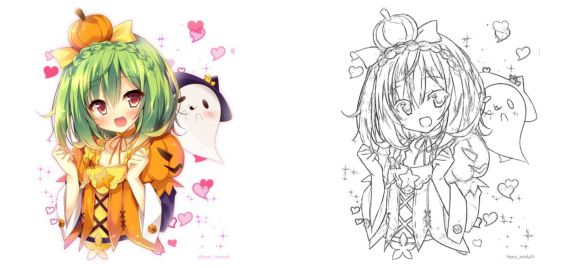

<PIL.Image.Image image mode=RGB size=1024x512 at 0x7FD378871190>


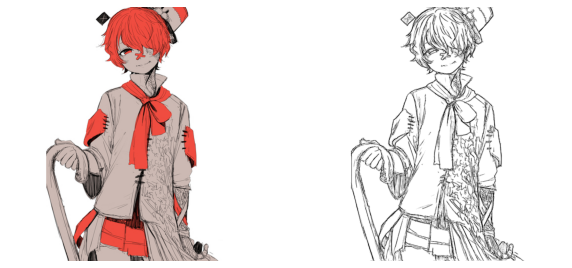

<PIL.Image.Image image mode=RGB size=1024x512 at 0x7FD378802A90>


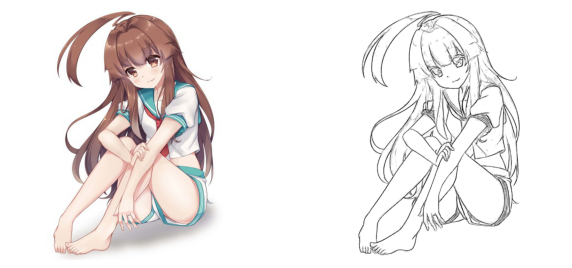

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import glob

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os


for file in glob.glob('/home/weiheng/Dataset/anime_sketch_color/data/train/*')[:3]:
    f, a = plt.subplots(1,2, figsize=(10,5))
    a = a.flatten()
    
    img = Image.open(file).convert('RGB')
    print(img)
    a[0].imshow(img.crop((0, 0, 512,512))); a[0].axis('off');
    a[1].imshow(img.crop((512, 0, 1024, 512))); a[1].axis('off');
    
    plt.show()
#     print(file)

### Custom Dataset Class

In [2]:
class DatasetFromFolder():
    def __init__(self, folder_path="trainData/", transform=transforms.Compose([transforms.ToTensor()])):
        if folder_path is not None:
            self.folder = folder_path
        else:
            raise Exception('No data folder provided')
    
        # Sketch Images Paths
        self.sketch_paths = self.getFileNames("Sketches/")
        self.data_len = len(self.sketch_paths)

        # Color Images Paths
        self.color_paths = self.getFileNames("Images/")
    
        self.transform = transform
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        # Read 1 sketch
        sketch_as_img = Image.open(self.sketch_paths[index])
        # Transform sketch to tensor
        sketch_as_tensor = self.transform(sketch_as_img)

        # Read 1 color image
        color_as_img = Image.open(self.color_paths[index])
        color_as_img = color_as_img.convert("RGB")
        # Transform color image to tensor
        color_as_tensor = self.transform(color_as_img)

        return sketch_as_tensor, color_as_tensor
    
    def getFileNames(self, subfolder):
        fileNames = glob.glob(self.folder+subfolder+"*")

        fileNames_sorted = sorted(fileNames,key=lambda x: int(os.path.split(os.path.splitext(x)[0])[1]))

        return fileNames_sorted

    
    
### Testing the Dataset Class
print("length of testData set: ", DatasetFromFolder("testData/").__len__())
print("Sketch 0: ", DatasetFromFolder("testData/").__getitem__(1)[0].shape)
print("Image 0: ", DatasetFromFolder("testData/").__getitem__(1)[1].shape)
# Image.open(DatasetFromFolder("testData/").sketch_paths[3540])

length of testData set:  3545
Sketch 0:  torch.Size([3, 512, 512])
Image 0:  torch.Size([3, 512, 512])


### Import dataset and put into dataloader

In [3]:
# define parameters
batchSize = 16
subset_size = 5500
val_size = 500
test_size = 1000
model_name = "MLP_v1"

# transform
transform_ = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

# split and load datasets
dataset = DatasetFromFolder(folder_path="trainData/", transform=transform_)
_size = len(dataset) - subset_size
subset, _ = random_split(dataset, [subset_size, _size])

train_size = len(subset) - val_size
trainSet, validSet = random_split(subset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True, num_workers=2)

test_dataset = DatasetFromFolder(folder_path="testData/", transform=transform_)
_size = len(test_dataset) - test_size
testSet, _ = random_split(test_dataset, [test_size, _size])
testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=True, num_workers=2)

print("trainSet size: ", len(trainSet))
print("validSet size: ", len(validSet))
print("testset size: ", len(testSet))

fixed_trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=False, num_workers=2)
fixed_testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False, num_workers=2)
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

trainSet size:  5000
validSet size:  500
testset size:  1000
cuda:0


### Pre-processing: Convert all rgb images to gray images

test_sketches:  torch.Size([16, 3, 32, 32])
test_colors:  torch.Size([16, 3, 32, 32])


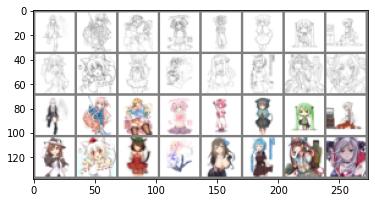

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# create folders
if not os.path.exists('./plot'):
    os.mkdir('./plot/')
if not os.path.exists('./plot/'+model_name+'/'):
    os.mkdir('./plot/'+model_name+'/')
if not os.path.exists('./plot/'+model_name+'/running_inference/'):
    os.mkdir('./plot/'+model_name+'/running_inference/')
if not os.path.exists('./plot/'+model_name+'/inference/'):
    os.mkdir('./plot/'+model_name+'/inference/')
if not os.path.exists('./saved_model'):
    os.mkdir('./saved_model/')

# functions to show an image
def imshow(img, name=""):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.savefig('plot/'+model_name+'/'+name+'.png')
    plt.show()
    
# get some random training images
dataiter = iter(testloader)
test_sketches, test_colors = dataiter.next()

print("test_sketches: ", test_sketches.shape)
print("test_colors: ", test_colors.shape)

testData_one_batch = torch.cat((test_sketches, test_colors), 0)
imshow(torchvision.utils.make_grid(testData_one_batch), name="testData_one_batch")

### Define the MLP network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 1x32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 3x32x32
        super(MLP_net, self).__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(3072, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            
            nn.Linear(4096, 5120),
            nn.BatchNorm1d(5120),
            nn.ReLU(),
            
            nn.Linear(5120, 3072),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        
        return x

model = MLP_net().to(device)

print("GPU: ", next(model.parameters()).is_cuda)

model_path = "./saved_model/"+model_name + ".pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load(model_path))

GPU:  True


### Define the loss function and optimizer

In [6]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# criterion
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) #betas=(0.9, 0.999), eps=1e-08, weight_decay=0
    # optimizer = optim.SGD(mlp_net.parameters(), lr=0.0001, momentum=0.9)

# load previous trained model 
if os.path.exists(model_path):
    print("Continue training from the saved model")
    model.load_state_dict(torch.load(model_path))
    
# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/"+model_name+"/")
plot_writer = SummaryWriter("./runs_plot/"+model_name+"/")

In [7]:
def make_grid(loaderName, k):
    images_sketch, images_color = next(iter(loaderName))
    print("images_color: ", images_color.shape)

    # run inference on the network
    images_sketch = images_sketch.to(device)
    outputs = model(images_sketch)
    outputs = outputs.reshape(batchSize, 3, 32, 32)
    print("outputs: ", outputs.shape)

    outputs = outputs.to("cpu")
    images_sketch  = images_sketch.to("cpu")
    images_color  = images_color.to("cpu")

    final_result_display = torch.cat((images_color, images_sketch, outputs), 0)
    imshow(torchvision.utils.make_grid(final_result_display.detach()), name="result_onTrainData_")
    
    imshow(torchvision.utils.make_grid(outputs.detach()), name="running_inference/trainData_"+str(format(k, '04d')))
    
    grid_output = torchvision.utils.make_grid(outputs.detach())
    plot_writer.add_image(str(loaderName), grid_output, k)

### Train the network

Training Mode...
[1,    50] train loss: 0.141
[1,   100] train loss: 0.137
[1,   150] train loss: 0.128
[1,   200] train loss: 0.131
[1,   250] train loss: 0.131
[1,   300] train loss: 0.124
Validation Mode...
[1, _] validation loss: 0.132
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


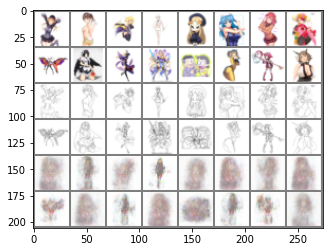

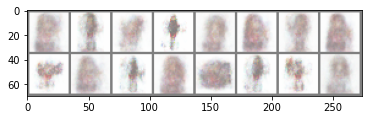

Training Mode...
[2,    50] train loss: 0.121
[2,   100] train loss: 0.123
[2,   150] train loss: 0.120
[2,   200] train loss: 0.118
[2,   250] train loss: 0.117
[2,   300] train loss: 0.119
Validation Mode...
[2, _] validation loss: 0.149
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


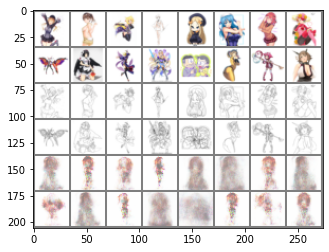

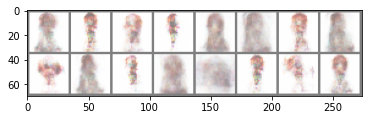

Training Mode...
[3,    50] train loss: 0.109
[3,   100] train loss: 0.112
[3,   150] train loss: 0.112
[3,   200] train loss: 0.118
[3,   250] train loss: 0.113
[3,   300] train loss: 0.115
Validation Mode...
[3, _] validation loss: 0.146
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


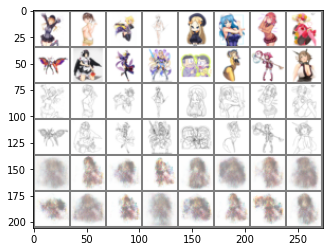

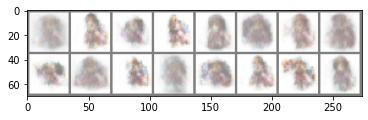

Training Mode...
[4,    50] train loss: 0.108
[4,   100] train loss: 0.102
[4,   150] train loss: 0.106
[4,   200] train loss: 0.104
[4,   250] train loss: 0.106
[4,   300] train loss: 0.107
Validation Mode...
[4, _] validation loss: 0.154
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


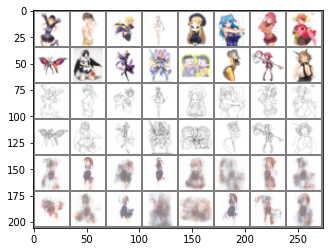

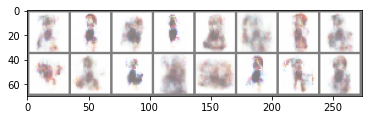

Training Mode...
[5,    50] train loss: 0.100
[5,   100] train loss: 0.096
[5,   150] train loss: 0.099
[5,   200] train loss: 0.101
[5,   250] train loss: 0.102
[5,   300] train loss: 0.098
Validation Mode...
[5, _] validation loss: 0.150
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


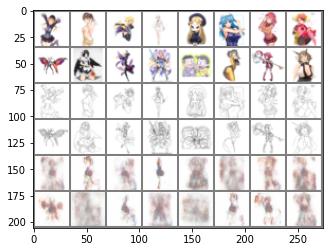

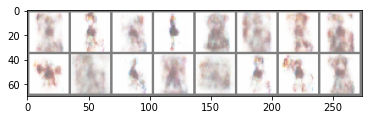

Training Mode...
[6,    50] train loss: 0.093
[6,   100] train loss: 0.091
[6,   150] train loss: 0.089
[6,   200] train loss: 0.095
[6,   250] train loss: 0.093
[6,   300] train loss: 0.092
Validation Mode...
[6, _] validation loss: 0.177
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


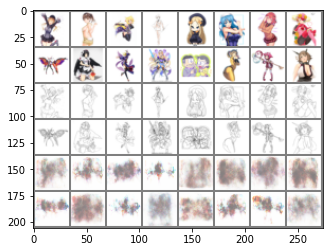

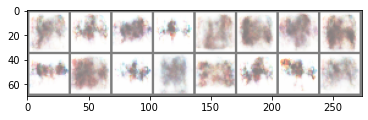

Training Mode...
[7,    50] train loss: 0.081
[7,   100] train loss: 0.082
[7,   150] train loss: 0.086
[7,   200] train loss: 0.089
[7,   250] train loss: 0.087
[7,   300] train loss: 0.086
Validation Mode...
[7, _] validation loss: 0.206
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


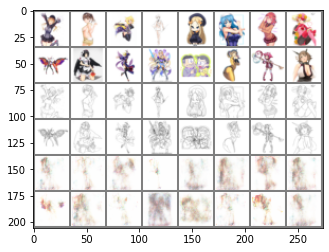

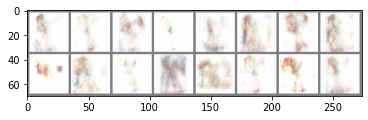

Training Mode...
[8,    50] train loss: 0.076
[8,   100] train loss: 0.081
[8,   150] train loss: 0.076
[8,   200] train loss: 0.081
[8,   250] train loss: 0.083
[8,   300] train loss: 0.084
Validation Mode...
[8, _] validation loss: 0.194
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


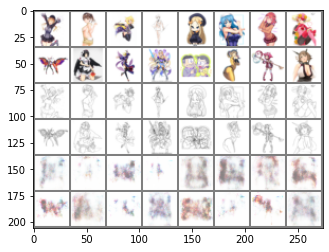

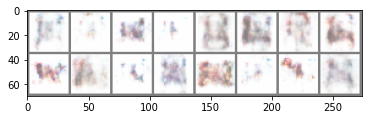

Training Mode...
[9,    50] train loss: 0.072
[9,   100] train loss: 0.073
[9,   150] train loss: 0.074
[9,   200] train loss: 0.076
[9,   250] train loss: 0.076
[9,   300] train loss: 0.077
Validation Mode...
[9, _] validation loss: 0.186
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


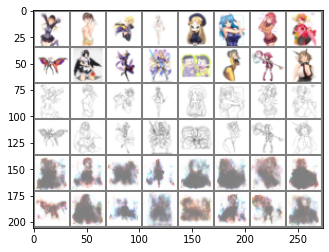

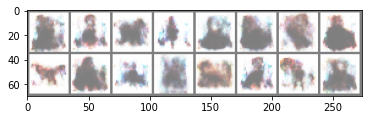

Training Mode...
[10,    50] train loss: 0.066
[10,   100] train loss: 0.066
[10,   150] train loss: 0.072
[10,   200] train loss: 0.072
[10,   250] train loss: 0.071
[10,   300] train loss: 0.074
Validation Mode...
[10, _] validation loss: 0.173
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


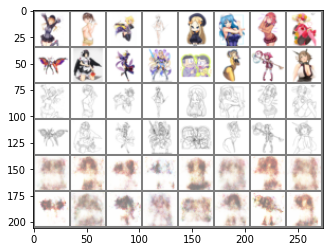

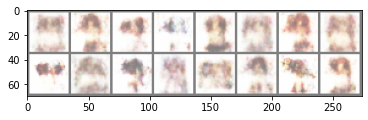

Training Mode...
[11,    50] train loss: 0.064
[11,   100] train loss: 0.064
[11,   150] train loss: 0.068
[11,   200] train loss: 0.065
[11,   250] train loss: 0.067
[11,   300] train loss: 0.066
Validation Mode...
[11, _] validation loss: 0.147
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


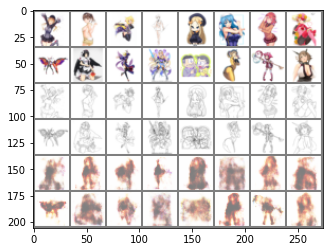

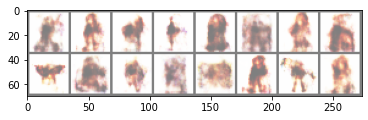

Training Mode...
[12,    50] train loss: 0.058
[12,   100] train loss: 0.061
[12,   150] train loss: 0.060
[12,   200] train loss: 0.063
[12,   250] train loss: 0.061
[12,   300] train loss: 0.064
Validation Mode...
[12, _] validation loss: 0.220
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


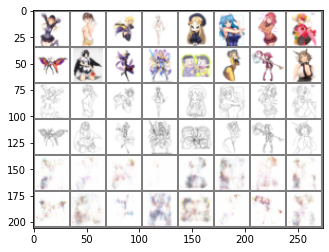

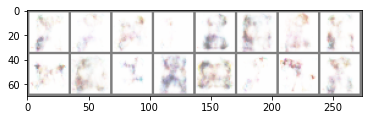

Training Mode...
[13,    50] train loss: 0.055
[13,   100] train loss: 0.058
[13,   150] train loss: 0.057
[13,   200] train loss: 0.058
[13,   250] train loss: 0.060
[13,   300] train loss: 0.059
Validation Mode...
[13, _] validation loss: 0.200
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


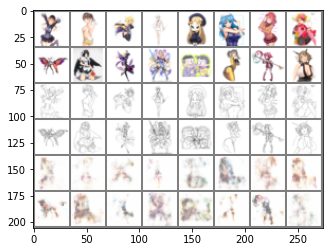

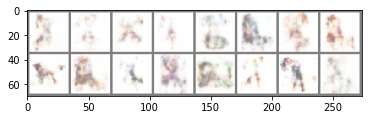

Training Mode...
[14,    50] train loss: 0.052
[14,   100] train loss: 0.055
[14,   150] train loss: 0.055
[14,   200] train loss: 0.056
[14,   250] train loss: 0.055
[14,   300] train loss: 0.058
Validation Mode...
[14, _] validation loss: 0.183
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


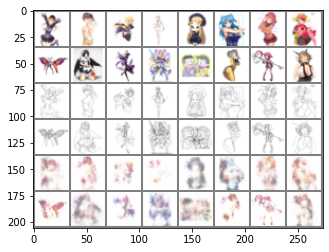

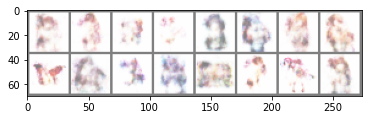

Training Mode...
[15,    50] train loss: 0.054
[15,   100] train loss: 0.052
[15,   150] train loss: 0.053
[15,   200] train loss: 0.052
[15,   250] train loss: 0.054
[15,   300] train loss: 0.056
Validation Mode...
[15, _] validation loss: 0.164
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


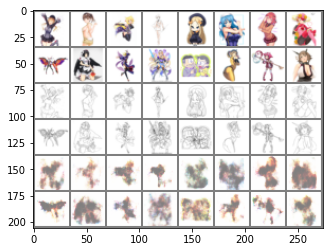

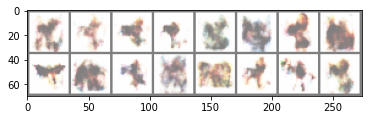

Training Mode...
[16,    50] train loss: 0.050
[16,   100] train loss: 0.052
[16,   150] train loss: 0.051
[16,   200] train loss: 0.052
[16,   250] train loss: 0.050
[16,   300] train loss: 0.052
Validation Mode...
[16, _] validation loss: 0.171
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


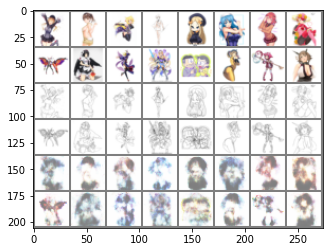

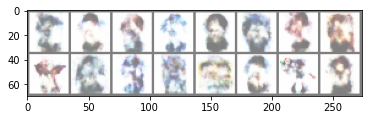

Training Mode...
[17,    50] train loss: 0.049
[17,   100] train loss: 0.049
[17,   150] train loss: 0.048
[17,   200] train loss: 0.050
[17,   250] train loss: 0.049
[17,   300] train loss: 0.050
Validation Mode...
[17, _] validation loss: 0.150
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


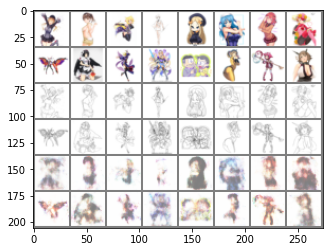

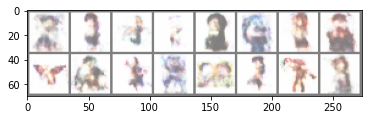

Training Mode...
[18,    50] train loss: 0.047
[18,   100] train loss: 0.045
[18,   150] train loss: 0.048
[18,   200] train loss: 0.049
[18,   250] train loss: 0.048
[18,   300] train loss: 0.048
Validation Mode...
[18, _] validation loss: 0.165
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


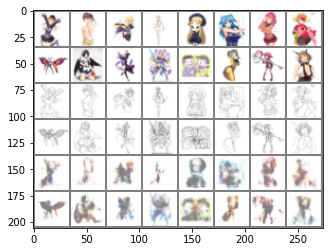

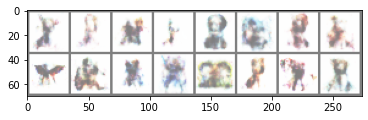

Training Mode...
[19,    50] train loss: 0.044
[19,   100] train loss: 0.047
[19,   150] train loss: 0.048
[19,   200] train loss: 0.045
[19,   250] train loss: 0.045
[19,   300] train loss: 0.048
Validation Mode...
[19, _] validation loss: 0.149
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


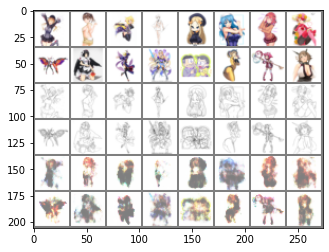

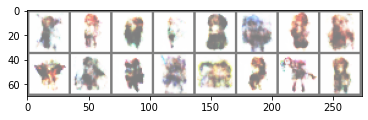

Training Mode...
[20,    50] train loss: 0.045
[20,   100] train loss: 0.044
[20,   150] train loss: 0.046
[20,   200] train loss: 0.046
[20,   250] train loss: 0.047
[20,   300] train loss: 0.042
Validation Mode...
[20, _] validation loss: 0.174
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


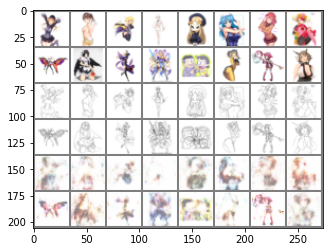

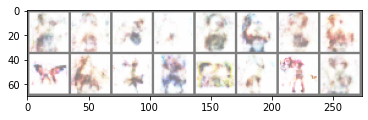

Training Mode...
[21,    50] train loss: 0.044
[21,   100] train loss: 0.044
[21,   150] train loss: 0.043
[21,   200] train loss: 0.045
[21,   250] train loss: 0.044
[21,   300] train loss: 0.044
Validation Mode...
[21, _] validation loss: 0.171
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


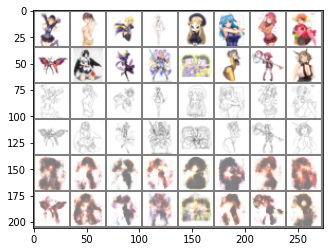

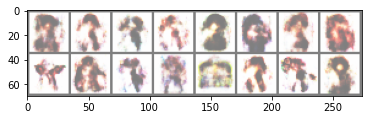

Training Mode...
[22,    50] train loss: 0.042
[22,   100] train loss: 0.042
[22,   150] train loss: 0.042
[22,   200] train loss: 0.043
[22,   250] train loss: 0.045
[22,   300] train loss: 0.044
Validation Mode...
[22, _] validation loss: 0.163
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


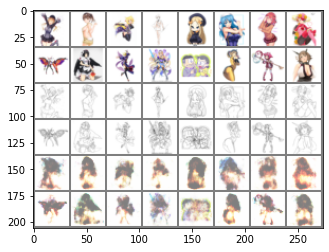

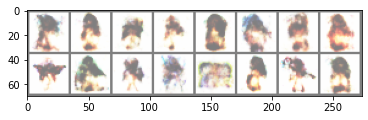

Training Mode...
[23,    50] train loss: 0.043
[23,   100] train loss: 0.039
[23,   150] train loss: 0.042
[23,   200] train loss: 0.042
[23,   250] train loss: 0.043
[23,   300] train loss: 0.041
Validation Mode...
[23, _] validation loss: 0.160
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


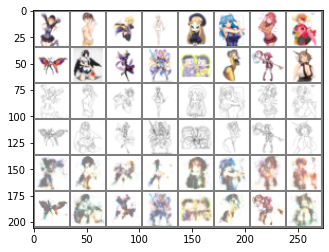

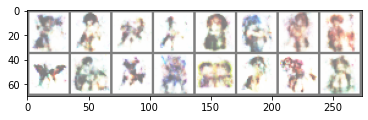

Training Mode...
[24,    50] train loss: 0.041
[24,   100] train loss: 0.040
[24,   150] train loss: 0.042
[24,   200] train loss: 0.041
[24,   250] train loss: 0.042
[24,   300] train loss: 0.043
Validation Mode...
[24, _] validation loss: 0.147
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


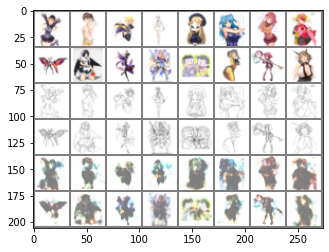

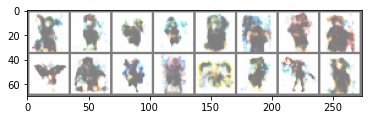

Training Mode...
[25,    50] train loss: 0.041
[25,   100] train loss: 0.040
[25,   150] train loss: 0.040
[25,   200] train loss: 0.039
[25,   250] train loss: 0.041
[25,   300] train loss: 0.043
Validation Mode...
[25, _] validation loss: 0.152
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


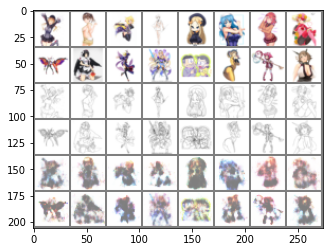

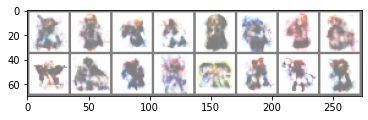

Training Mode...
[26,    50] train loss: 0.039
[26,   100] train loss: 0.037
[26,   150] train loss: 0.041
[26,   200] train loss: 0.039
[26,   250] train loss: 0.042
[26,   300] train loss: 0.040
Validation Mode...
[26, _] validation loss: 0.163
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


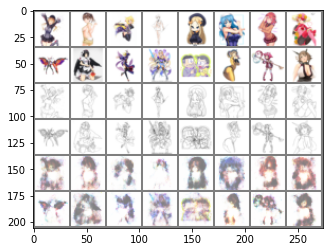

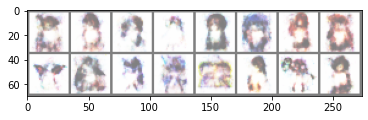

Training Mode...
[27,    50] train loss: 0.038
[27,   100] train loss: 0.039
[27,   150] train loss: 0.038
[27,   200] train loss: 0.038
[27,   250] train loss: 0.039
[27,   300] train loss: 0.042
Validation Mode...
[27, _] validation loss: 0.166
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


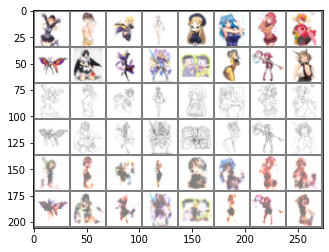

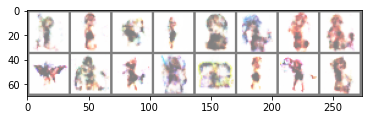

Training Mode...
[28,    50] train loss: 0.039
[28,   100] train loss: 0.038
[28,   150] train loss: 0.037
[28,   200] train loss: 0.039
[28,   250] train loss: 0.038
[28,   300] train loss: 0.041
Validation Mode...
[28, _] validation loss: 0.154
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


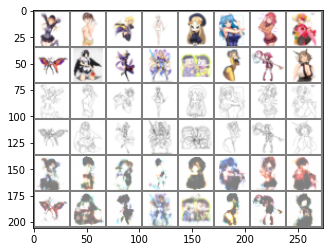

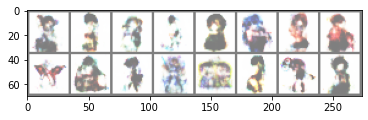

Training Mode...
[29,    50] train loss: 0.039
[29,   100] train loss: 0.038
[29,   150] train loss: 0.038
[29,   200] train loss: 0.037
[29,   250] train loss: 0.038
[29,   300] train loss: 0.039
Validation Mode...
[29, _] validation loss: 0.166
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


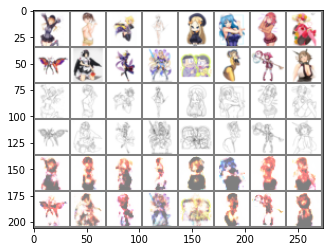

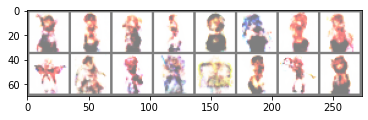

Training Mode...
[30,    50] train loss: 0.037
[30,   100] train loss: 0.037
[30,   150] train loss: 0.037
[30,   200] train loss: 0.038
[30,   250] train loss: 0.037
[30,   300] train loss: 0.038
Validation Mode...
[30, _] validation loss: 0.170
images_color:  torch.Size([16, 3, 32, 32])
outputs:  torch.Size([16, 3, 32, 32])


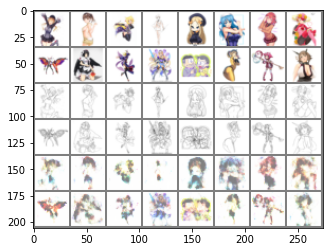

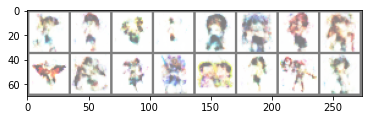

Training Mode...
[31,    50] train loss: 0.037
[31,   100] train loss: 0.039


KeyboardInterrupt: 

In [8]:
for epoch in range(100):  # loop over the dataset multiple times
    train_running_loss = 0.0
    valid_running_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    print("Training Mode...")
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        sketches, colors = data
        
        # put data in gpu/cpu
        sketches = sketches.to(device)
        colors = colors.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - sketches: [batchSize,3,512,512]
#         print("sketches: ", sketches.shape)
        outputs = model(sketches)
    
        # Backward
        # Size - images_color: [batchSize,3,512,512]
        # Size - outputs: [batchSize,3,512,512]
        colors_flat = colors.reshape(colors.shape[0], -1)
        train_loss = criterion(outputs, colors_flat)
        train_loss.backward()
        optimizer.step()

        # print output statistics
        train_running_loss += train_loss.item()
        
        j = 50              # print every j mini-batches
        if i % j == (j-1):     # print every j mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, train_running_loss / j))
            
            writer.add_scalar('Loss/train', train_running_loss/j, len(trainloader)*epoch + i)
            train_running_loss = 0.0
        
    ###################
    # validate the model #
    ###################
    model.eval()
    print("Validation Mode...")
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            sketches, colors = data

            # put data in gpu/cpu
            sketches = sketches.to(device)
            colors = colors.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Size - sketches: [batchSize,3,512,512]
    #         print("sketches: ", sketches.shape)
            outputs = model(sketches)

            # Backward
            # Size - images_color: [batchSize,3,512,512]
            # Size - outputs: [batchSize,3,512,512]
            colors_flat = colors.reshape(colors.shape[0], -1)
            valid_loss = criterion(outputs, colors_flat)

            # print output statistics
            valid_running_loss += valid_loss.item()
    
        print('[%d, _] validation loss: %.3f' %
              (epoch + 1, valid_running_loss/(i+1)))

        writer.add_scalar('Loss/valid', valid_running_loss/(i+1), len(trainloader)*(epoch+1))
        valid_running_loss = 0.0
        
    # Save the summary of output image, after each epoch
    make_grid(fixed_trainloader, epoch)

writer.flush()
writer.close()
plot_writer.flush()
plot_writer.close()
print('Finished Training')

### Inference

In [ ]:
def inference(loaderName, prefix):
    
    images_color, _ = next(iter(loaderName))
    print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
    imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference/"+prefix+"color")

    images_gray = rgb2gray_batch(images_color)
    print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
    imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference/"+ prefix+"gray")

    # run inference on the network
    images_gray = images_gray.to(device)
    outputs = model(images_gray)
    outputs = outputs.reshape(batchSize,3,32,32)
    outputs = outputs.to("cpu")
    imshow(torchvision.utils.make_grid(outputs.detach()), name="inference/"+prefix+"output")

In [ ]:
inference(fixed_trainloader, "train")
inference(trainloader, "train")
inference(validloader, "valid")
inference(testloader, "test")

### Test the model

In [ ]:
###################
# test the model #
###################
model.eval()
test_running_loss = 0.0
print("Test Mode...")
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)

        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)

        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        test_loss = criterion(outputs, images_color_flat)

        # print output statistics
        test_running_loss += test_loss.item()

    print('test loss: %.5f' %
          (test_running_loss/(i+1)))

### Save the model

In [ ]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')
torch.save(model.state_dict(), model_path)